<a href="https://colab.research.google.com/github/ShivaKondapalli/VisionColabNotebooks/blob/master/Copy_of_lesson3_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_dir

'/content/gdrive/My Drive/fastai-v3/'

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
! {sys.executable} -m pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
path.ls()

[]

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 593M/600M [00:13<00:00, 27.8MB/s]
100% 600M/600M [00:13<00:00, 46.2MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 76.9MB/s]


In [0]:
# we have now downloaded all the from kaggle into their respective directories
path.ls()

[PosixPath('/root/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/root/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/root/.fastai/data/planet/__MACOSX'),
 PosixPath('/root/.fastai/data/planet/train_v2.csv')]

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [0]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

! sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [0]:
# Here we unpack train_v2.csv.zip 
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
# insepct the contents of the folder to see if train-jpg is present 
path.ls()

[PosixPath('/root/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/root/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/root/.fastai/data/planet/train-jpg'),
 PosixPath('/root/.fastai/data/planet/__MACOSX'),
 PosixPath('/root/.fastai/data/planet/train_v2.csv')]

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.tail(10)

,image_name,tags
40469,train_40469,haze primary water
40470,train_40470,clear habitation primary road
40471,train_40471,clear primary
40472,train_40472,agriculture clear primary
40473,train_40473,agriculture clear habitation primary road
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


In [0]:
df.shape

(40479, 2)

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes. 

In [0]:
# utlity fucntion that filps, rotates, zooms into and warps our images to help our model generalize
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

# perspective warping changes the perspective from which you see the images, i.e. down or below, closer or farther away

In [0]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [0]:
import os 

# all our images are in "/root/.fastai/data/planet"
# check if it is directory 

print(path)
print(os.path.isdir(path))

/root/.fastai/data/planet
True


In [0]:
# print out the files in path 
fnames = os.listdir(path)
fnames

['train_v2.csv.zip',
 'train-jpg.tar.7z',
 'train-jpg',
 '__MACOSX',
 'train_v2.csv']

In [0]:
# use get_image_files to get the files in 'train-jpg'

all_images = get_image_files(path/'train-jpg')
print(all_images[:3])
len(all_images)

[PosixPath('/root/.fastai/data/planet/train-jpg/train_17353.jpg'), PosixPath('/root/.fastai/data/planet/train-jpg/train_296.jpg'), PosixPath('/root/.fastai/data/planet/train-jpg/train_38787.jpg')]


40479

In [0]:
# inspect the ImageList.from_csv factory method, this is just for practise
# ??ImageList.from_csv()

# src = (ImageList.from_csv(path, 'train_v2.csv', 'train-jpg', suffix='jpg')
# .split_by_rand_pct(0.2).label_from_df(cols='Tags', sep=''))

Create a DataBunch object from the images in 'path/train-jpg'' and the csv file mapping each image in the aformentioned folder to  thier respective labels in the 'Tags' column. 

We will then feed this object to our model cnn_leaner(data, models.resnet34) for training.


We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add  '\\'.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
# now use the tfms previously defined
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
# grab a sample from the data bunch
print(data.train_ds[1])

# check the length of training data
print(len(data.train_ds))

# do the same for validation
print(data.valid_ds[1])
print(len(data.valid_ds))

(Image (3, 128, 128), MultiCategory clear;primary)
32384
(Image (3, 128, 128), MultiCategory clear;primary;water)
8095


In [0]:
data.train_ds.classes # total of 17 different classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

`show_batch` still works, and show us the different labels separated by `;`.

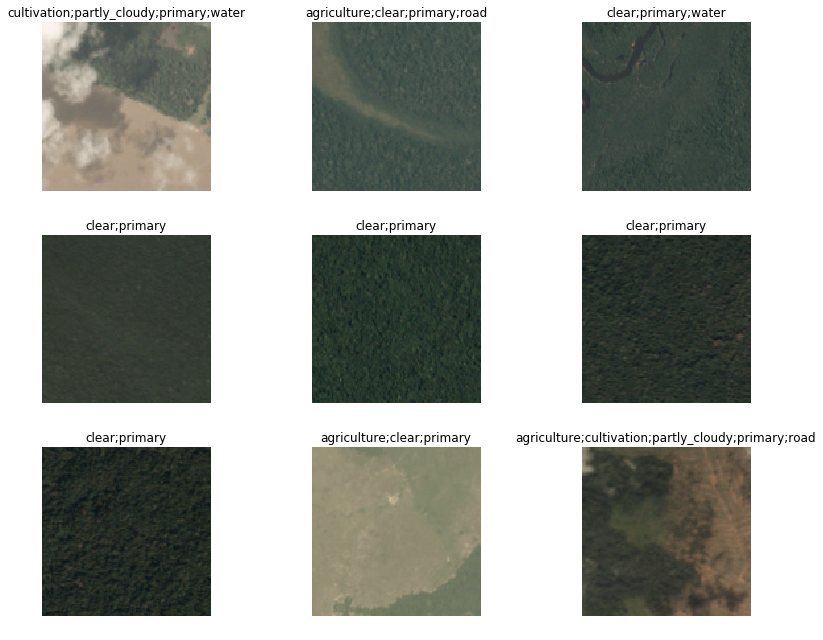

In [0]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [0]:
print(len(data.classes))
print(data.c)

# each prediction will give 17 different possiblities. We then pick all those values which are bigger than a particular threshold.
# accuracy uses argmax(dim=1) to find the largest prob and return the corresponding index
# but instead we use accuracy_thresh, this compares each prob and retunrs those higher than the threshold

17
17


In [0]:
help(accuracy_thresh)

Help on function accuracy_thresh in module fastai.metrics:

accuracy_thresh(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.5, sigmoid:bool=True) -> <function NewType.<locals>.new_type at 0x7f575ea530d0>
    Computes accuracy when `y_pred` and `y_true` are the same size.



In [0]:
doc(fbeta)

In [0]:
# we can code accurcy_thresh the following way 

def acc_02(pred, target):
  return accuracy_thresh(pred, target, thresh=0.2) 

# we can use partial function application from functools to call accuracy_thresh with a threshold of 2

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 105365836.92it/s]


We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


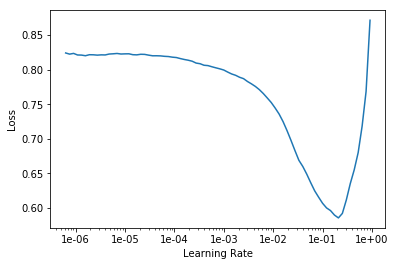

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126888,0.107684,0.943298,0.904039,02:43
1,0.110233,0.098281,0.944904,0.912452,02:42
2,0.103159,0.092669,0.957170,0.918330,02:40
3,0.097348,0.088356,0.954227,0.924216,02:38
4,0.092248,0.087394,0.957766,0.926072,02:37


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model. This means we unfreeze the weights of the whole network, And then start trainining our model.

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


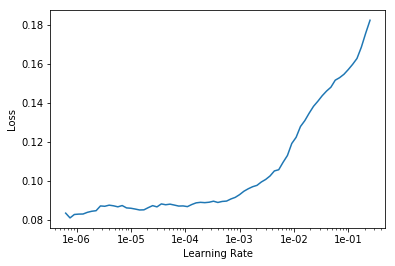

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094781,0.092684,0.955506,0.919549,02:46
1,0.094813,0.090322,0.954794,0.921011,02:48
2,0.088551,0.086186,0.958151,0.926482,02:47
3,0.084393,0.083604,0.959118,0.928133,02:47
4,0.079931,0.082553,0.958180,0.929425,02:45


Now that we have fine-tined our model by using all the weights of our model. let us save it. 

In [0]:
learn.save('stage-2-rn50')

## Increasing Image resolution and using our pre-trained model on 128*128 size dataset

We trained our model on 128 * 128 image resolution. We trained only the final layers, we also used the whole network. Let us create a seperate databunch using ImageList.from_csv() which contains images which 256 * 256. Let us then use the model on 128 * 128 as a pre-trained model. 

In [0]:
# create a new databunch object with size=256
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

# change the data in learn object
# remember learner = cnn_learner(data, models.resnet50, metric=[acc_02, fbeta])
# change data atribute of learner and place in the new data
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
# inspect an element
print(data.train_ds[5])

# as we can see, the shape is 256 * 256

(Image (3, 256, 256), MultiCategory agriculture;clear;cultivation;primary)


In [0]:
# freeze all the conv layers, use only the final classifier
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


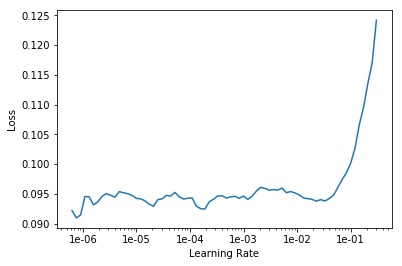

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089071,0.085220,0.957607,0.926743,05:19
1,0.087672,0.083883,0.955281,0.928268,05:18
2,0.082601,0.083193,0.961414,0.928622,05:17
3,0.082413,0.081669,0.958362,0.929948,05:18
4,0.080312,0.081053,0.958529,0.930293,05:17


93% accuracy is really great. Let us Save this and continue training by unfreezing all the layers on the 256 * 256 images. But do remember that we are using the 128 * 128 model as the starting point. 

In [0]:
learn.save('stage-1-256-rn50', )

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Unfreezing the layers did not help much, as such let us use the stage 1 model iwth 256 resolution.

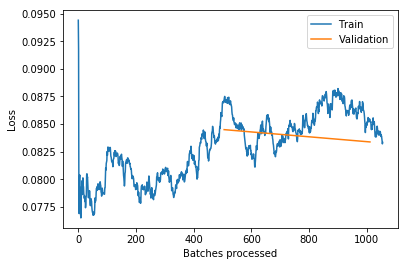

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.export('train_resnet_model_50.pkl')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/root/.fastai/data/planet/train_resnet_model_50.pkl'),
 PosixPath('/root/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/root/.fastai/data/planet/train-jpg'),
 PosixPath('/root/.fastai/data/planet/__MACOSX'),
 PosixPath('/root/.fastai/data/planet/models'),
 PosixPath('/root/.fastai/data/planet/train_v2.csv')]

In [0]:
!pwd

/content


In [0]:
from google.colab import files
files.download('/root/.fastai/data/planet/train_resnet_model_50.pkl')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)